# Dynamic Events in CADET-Process

Dynamic changes of model parameters or flow sheet connections are configure in `Process` class.

For more information, see also [here](https://cadet-process.readthedocs.io/en/latest/user_guide/process_model/process.html).

First, let's re-create the example from the last lesson. The parameters were:
```
inlet.flow_rate = 1e-6
inlet.c = 1
column.total_porosity = 0.4
column.length = 0.1  # m
column.diameter = 0.2  # m
column.axial_dispersion = 1e-7  # m^2 s^-1
process.cycle_time = 2000  # s
```

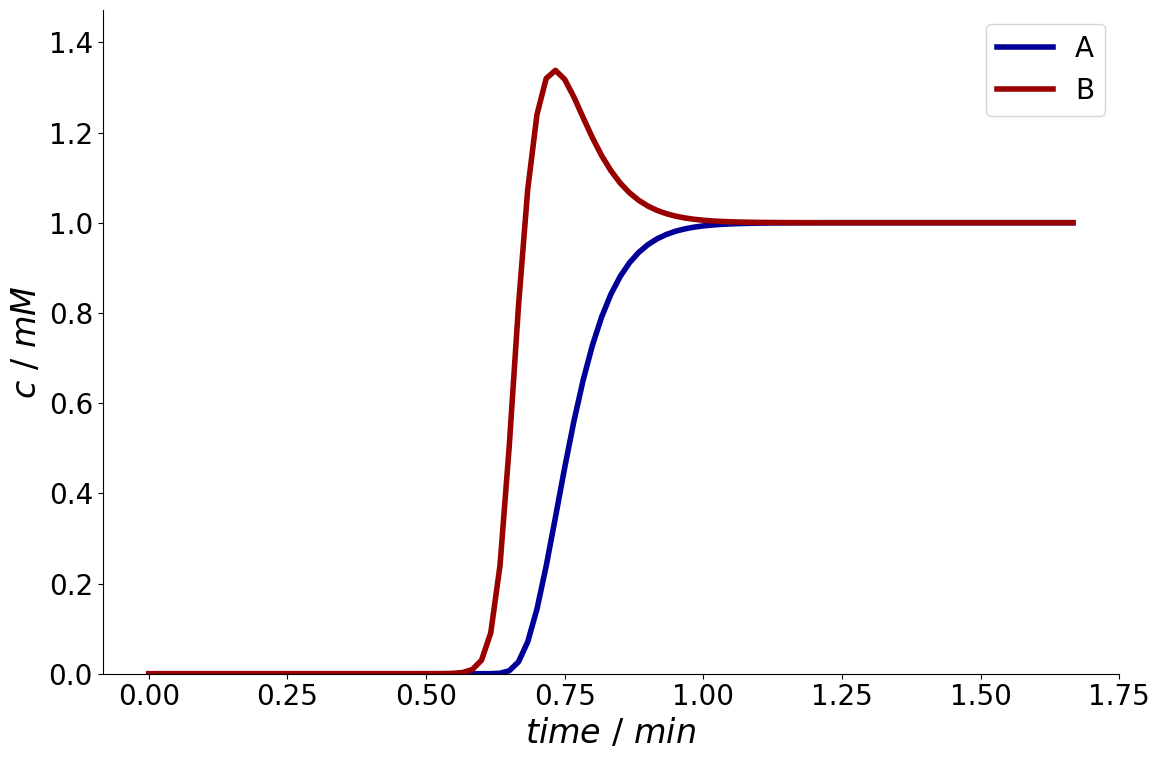

In [28]:
from CADETProcess.processModel import ComponentSystem

component_system = ComponentSystem(['A', 'B'])

from CADETProcess.processModel import Langmuir

binding_model = Langmuir(component_system, name='linear')
binding_model.is_kinetic = False
binding_model.adsorption_rate = [2, 1]
binding_model.desorption_rate = [1, 1]
binding_model.capacity = [1, 1]

from CADETProcess.processModel import Inlet, Outlet, LumpedRateModelWithoutPores

column = LumpedRateModelWithoutPores(component_system, name="reactor")
column.binding_model = binding_model

column.length = 0.014
column.total_porosity = 0.4
column.diameter = 0.01
column.axial_dispersion = 1e-7

inlet = Inlet(component_system, name='inlet')
inlet.c = [1.0, 1.0]
inlet.flow_rate = 1.67e-8

outlet = Outlet(component_system, name= 'outlet')


from CADETProcess.processModel import FlowSheet

flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(column)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(inlet,column)
flow_sheet.add_connection(column,outlet)

from CADETProcess.processModel import Process

process = Process(flow_sheet, 'process')
process.cycle_time = 100

from CADETProcess.simulator import Cadet
simulator = Cadet()
simulator.time_resolution = 1

sim_results = simulator.run(process)
_ = sim_results.solution.reactor.outlet.plot()

Rarely do we want to simulate static processes. All events, such as pump changes, injections, valve changes etc. need to be configured in the `Process` class.

To add an event that changes the value of a parameter, use the `add_event` method which requires the following arguments:
- `name`: Name of the event.
- `parameter_path`: Path of the parameter that is changed in dot notation. E.g. the flow rate of the eluent unit is the parameter `flow_rate` of the `eluent` unit in the `flow_sheet`. Hence, the path is `flow_sheet.eluent.flow_rate`. As previously mentioned, the name of the unit operation is used to reference it, not the variable.
- `state`: Value of the attribute that is changed at Event execution.
- `time`: Time at which the event is executed.

To display all time dependent parameters of an object, use the `section_dependent_parameters` attribute.

In [29]:
# process.add_event("load_start", "flow_sheet.inlet.c", 1, time=0, indices=(0, 1))
# process.add_event("load_stop", "flow_sheet.inlet.c", 0, time=10)

Note that also flow sheet connectivity can be added as events. More on that later.

In [30]:
# process.add_event("load_start", "flow_sheet.inlet.c", [0, 1, 0, 0], time=0, indices=(0,))

Now, add an event to start loading the column with 1 mM of our component when we start the simulation and an event to wash the column with an eluent with 0 mM of our component after 60 seconds.

In [31]:
inlet.c = [0, 1]

All events can are stored in the events attribute. To visualize the trajectory of the parameter state over the entire cycle, the Process provides a `plot_events()` method.

In [32]:
process.plot_events()

[]

Now create a simulator and simulate and plot the process.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='$time~/~min$', ylabel='$c~/~mM$'>)

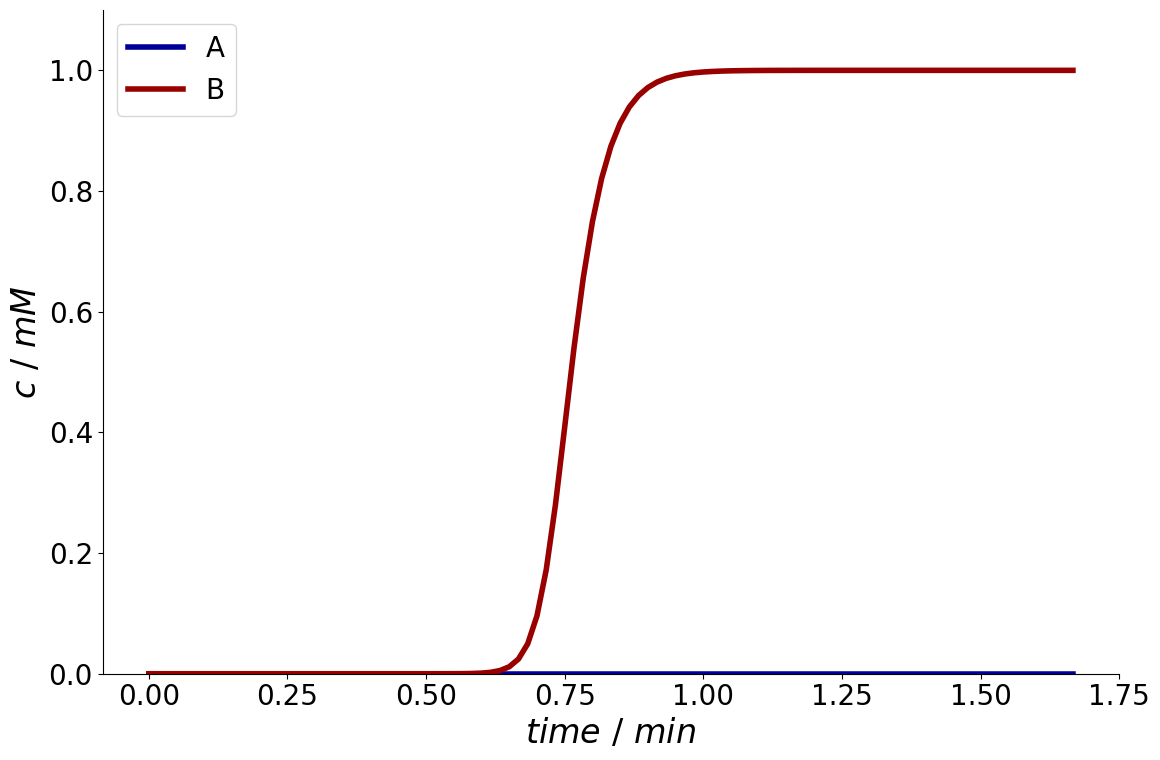

In [33]:
sim_results = simulator.simulate(process)
sim_results.solution.outlet.outlet.plot()

We are not limited to constant concentrations. We can set piecewise cubic polynomials for:
- Concentration profiles (for each component) and
- Flow rate

Here's an overview of piecewise functions and how they approximate a sine wave.
```{figure} ./resources/piecewise.png
:width: 50%
:align: left

source: https://bayesiancomputationbook.com/_images/piecewise.png
```

So let's set a gradient inlet that starts at 50 mM and increases linearly to 1000 mM over 60 minutes (3600 s). First, we need a new `Process` instance.

In [34]:
slope = (1000 - 50) / 3600

process.add_event("gradient_start", "flow_sheet.inlet.c", [50, slope], time=0, indices=[(0, 0), (0, 1)])
# process.add_event("load_stop", "flow_sheet.inlet.c", 0, time=10)

Event(name=gradient_start, parameter_path=flow_sheet.inlet.c, state=[50, 0.2638888888888889], time=0.0, indices=[(0, 0), (0, 1)])

[<Axes: title={'center': 'flow_sheet.inlet.c'}, xlabel='$time~/~min$', ylabel='$state$'>]

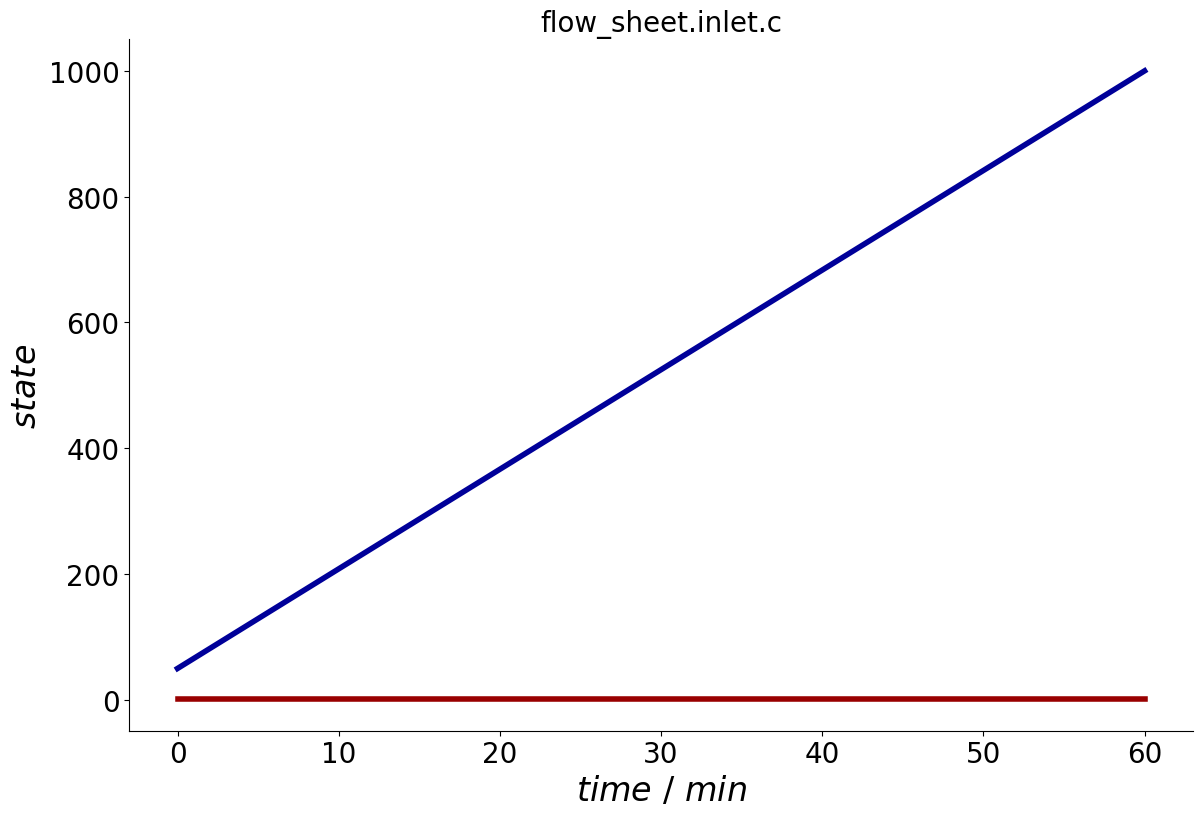

In [36]:
process.cycle_time = 3600
process.plot_events()

We can also add event dependencies. These set the time of events depending on the time of other events.

So we could set the gradient to start 100 seconds after a loading phase has started.

Lastly, we can add durations to the process to use them in event dependencies: